# SingleCell Data Analysis on the CPU
**Author:** [Severin Dicks](https://github.com/Intron7) (IBSM Freiburg)

To run this notebook please make sure you have a working enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time


import matplotlib.pyplot as plt
from matplotlib import rcParams

sc.set_figure_params(dpi= 100, dpi_save = 300)
rcParams['figure.figsize'] = 5,5


## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. 

In [2]:
data_load_start = time.time()

In [3]:
%%time
adata=sc.read("h5/adata.raw.h5ad")

CPU times: user 84.5 ms, sys: 108 ms, total: 193 ms
Wall time: 193 ms


In [4]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 0.20253324508666992


## Preprocessing

In [5]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

Some genes will now have zero expression in all cells. We filter out such genes.

In [6]:
%%time
adata.var['MT'] = adata.var_names.str.startswith('MT-') 

CPU times: user 5.46 ms, sys: 0 ns, total: 5.46 ms
Wall time: 5.37 ms


In [7]:
%%time
adata.var['RIBO'] = adata.var_names.str.startswith('RPS') 


CPU times: user 4.28 ms, sys: 0 ns, total: 4.28 ms
Wall time: 4.18 ms


In [8]:
%%time
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

CPU times: user 857 ms, sys: 63.7 ms, total: 921 ms
Wall time: 919 ms


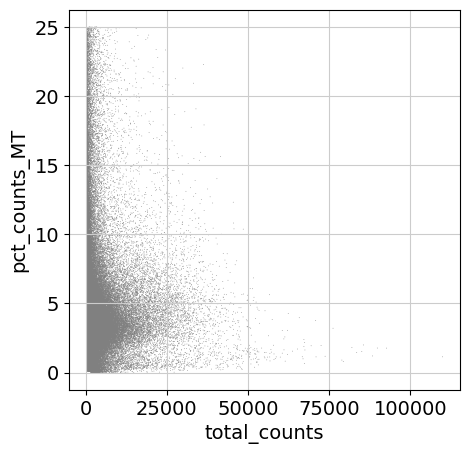

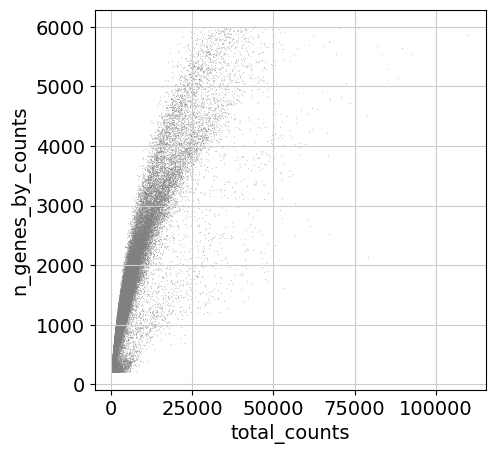

In [9]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

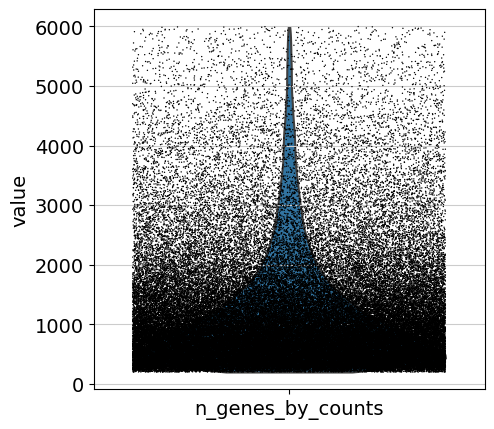

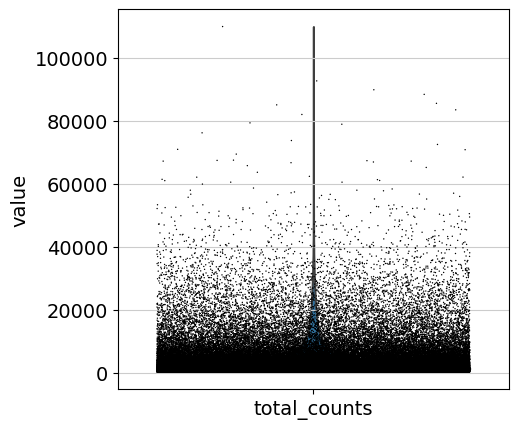

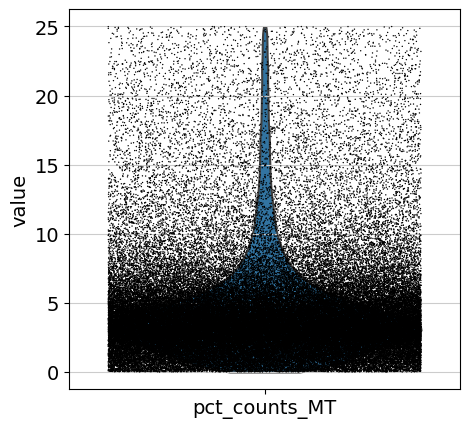

In [10]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, group_by="PatientNumber")
sc.pl.violin(adata, 'total_counts',jitter=0.4, group_by="PatientNumber")
sc.pl.violin(adata, 'pct_counts_MT',jitter=0.4, group_by="PatientNumber")


### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

The size of our count matrix is now reduced.

In [11]:
%%time
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[adata.obs.pct_counts_MT < 20, :]

CPU times: user 16.3 ms, sys: 281 µs, total: 16.5 ms
Wall time: 15.4 ms


In [12]:
%%time
sc.pp.filter_genes(adata, min_cells=3)

Trying to set attribute `.var` of view, copying.


CPU times: user 692 ms, sys: 265 ms, total: 957 ms
Wall time: 957 ms


Some genes will now have zero expression in all cells. We filter out such genes.

In [13]:
adata.shape

(91180, 25365)

In [14]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 272 ms, sys: 18.9 ms, total: 291 ms
Wall time: 291 ms


### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [15]:
%%time
sc.pp.normalize_total(adata,target_sum=1e4)

CPU times: user 264 ms, sys: 26.2 ms, total: 290 ms
Wall time: 290 ms


Next, we log transform the count matrix.

In [16]:
%%time
sc.pp.log1p(adata)

CPU times: user 830 ms, sys: 0 ns, total: 830 ms
Wall time: 829 ms


### Select Most Variable Genes

We will now select the most variable genes in the dataset.

In [17]:
%%time
sc.pp.highly_variable_genes(adata,batch_key="PatientNumber")

CPU times: user 2.73 s, sys: 270 ms, total: 3 s
Wall time: 3 s


Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use

In [18]:
%%time
adata.raw = adata

CPU times: user 32 ms, sys: 52.5 ms, total: 84.4 ms
Wall time: 83.6 ms


Restrict adata to only the highly variable genes

In [19]:
%%time
adata = adata[:, adata.var.highly_variable]

CPU times: user 54.6 ms, sys: 35.8 ms, total: 90.4 ms
Wall time: 89.8 ms


In [20]:
adata.shape

(91180, 2463)

Next we regess out effects of counts per cell and the mitochondrial content of the cells. 

In [21]:
%%time
sc.pp.regress_out(adata,keys=["total_counts", "pct_counts_MT"])

CPU times: user 11min 22s, sys: 30min 19s, total: 41min 42s
Wall time: 1min 19s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [22]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 645 ms, sys: 51.8 ms, total: 697 ms
Wall time: 697 ms


We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [23]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 88.30239748954773


## Clustering and Visulization

### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. 

In [24]:
%%time
sc.tl.pca(adata, n_comps = 100)

CPU times: user 5min 51s, sys: 4min 9s, total: 10min 1s
Wall time: 19.5 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

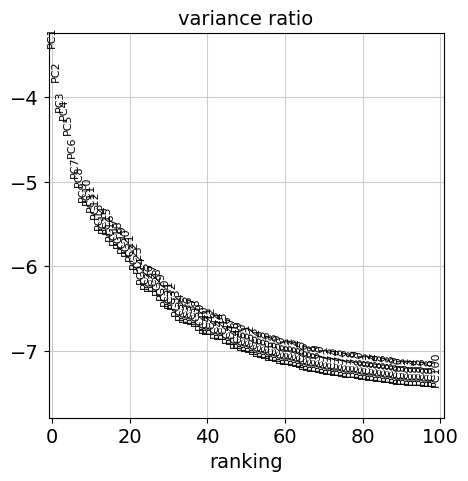

In [25]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph and UMAP

In [26]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

CPU times: user 26.7 s, sys: 5.93 s, total: 32.7 s
Wall time: 15.5 s


In [27]:
%%time
sc.tl.umap(adata)

CPU times: user 2min 47s, sys: 55 s, total: 3min 42s
Wall time: 31 s


### Clustering
We cluster the cells with the Leiden and Louvain algorithm

In [28]:
%%time
sc.tl.louvain(adata)

CPU times: user 8.38 s, sys: 33.1 ms, total: 8.41 s
Wall time: 8.41 s


In [29]:
%%time
sc.tl.leiden(adata)

CPU times: user 13.5 s, sys: 77.5 ms, total: 13.6 s
Wall time: 13.6 s


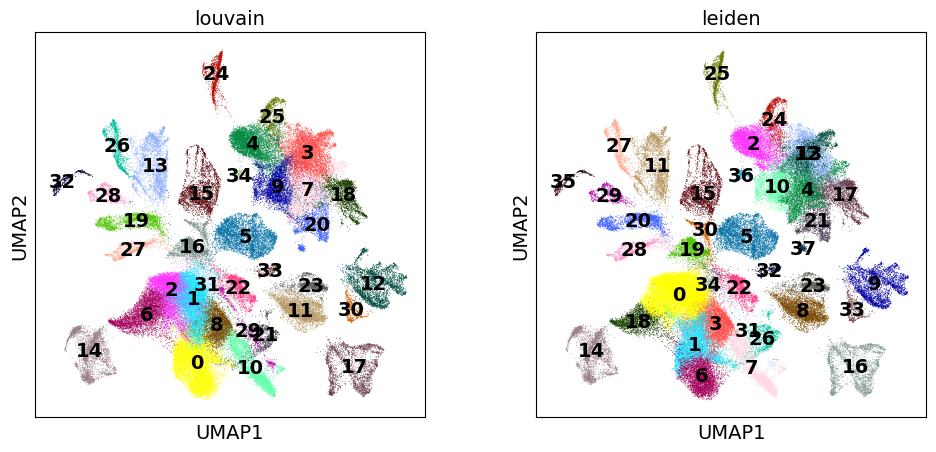

CPU times: user 577 ms, sys: 1.68 ms, total: 579 ms
Wall time: 584 ms


In [30]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

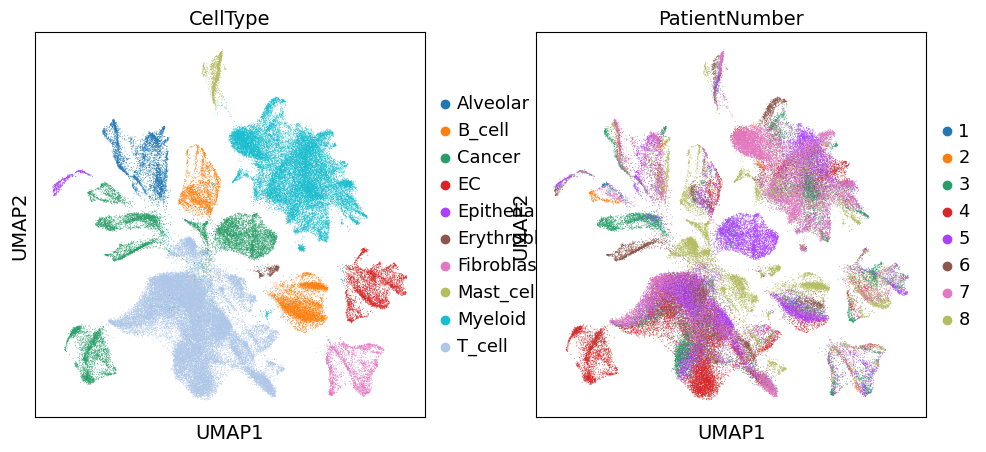

In [31]:
sc.pl.umap(adata, color= ["CellType", "PatientNumber"])

### TSNE + K-means
You might want to skip this step. Calucating a TSNE for 90000 cells takes really long 

In [33]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

In [34]:
%%time
sc.tl.tsne(adata, n_pcs = 40, n_jobs=-1)

CPU times: user 30min 52s, sys: 20min 50s, total: 51min 42s
Wall time: 3min 46s


... storing 'kmeans' as categorical


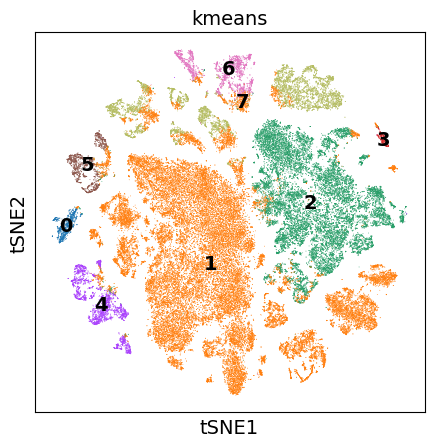

In [35]:
sc.pl.tsne(adata,color=["kmeans"], legend_loc='on data')

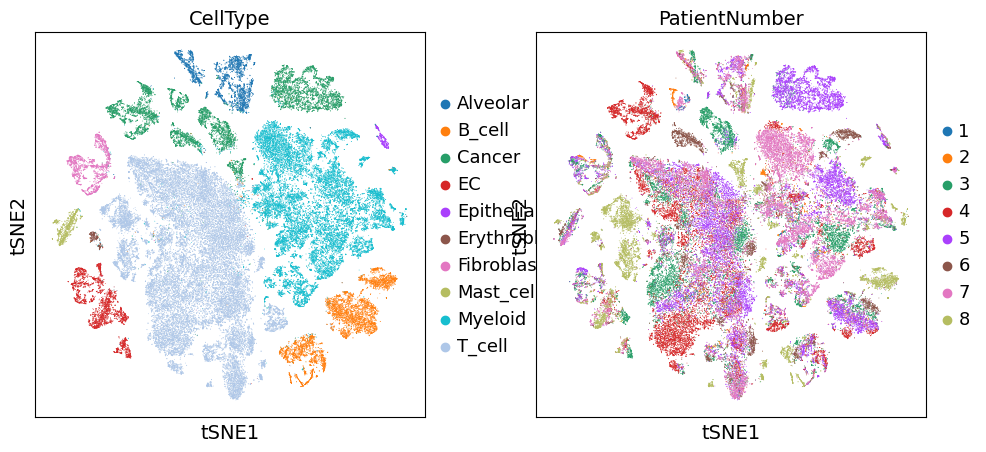

CPU times: user 659 ms, sys: 955 µs, total: 660 ms
Wall time: 659 ms


In [36]:
%%time
sc.pl.tsne(adata, color= ["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

In [37]:
%%time
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg', use_raw=False)

CPU times: user 23min 45s, sys: 14min 15s, total: 38min
Wall time: 1min 14s


/home/sdicks/miniconda3/envs/rapids-0.19/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


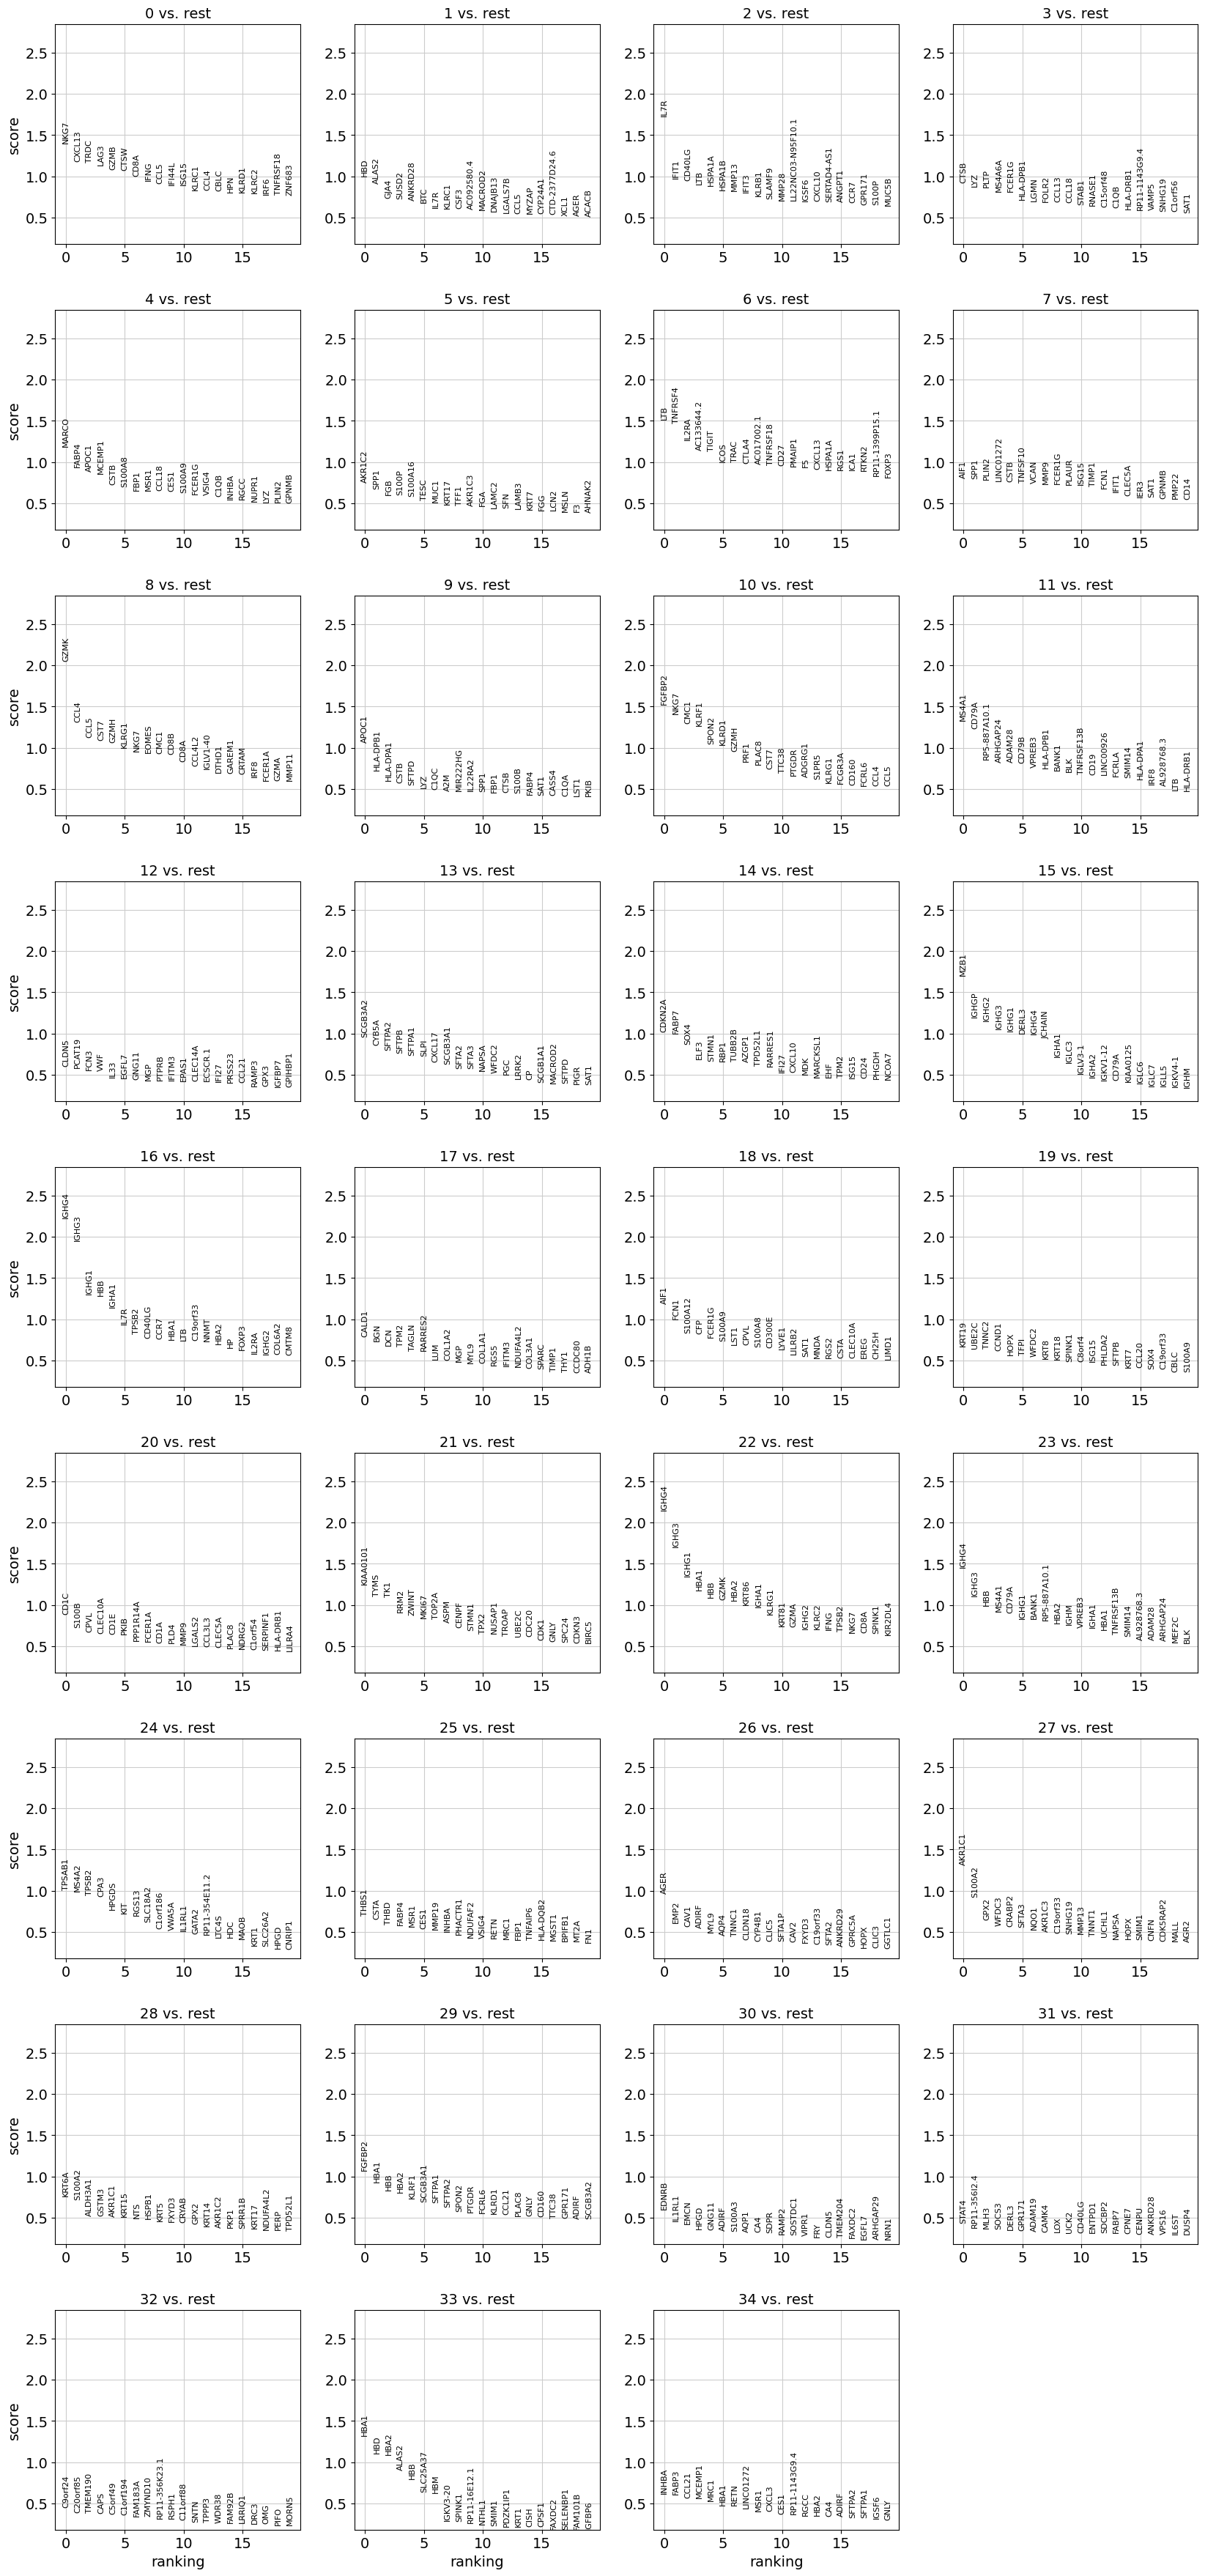

CPU times: user 2.46 s, sys: 72.2 ms, total: 2.53 s
Wall time: 2.53 s


In [38]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [39]:
post_time = time.time()

In [40]:
print("Total Postprocessing time: %s" % (post_time-preprocess_time))

Total Postprocessing time: 467.68324303627014


## Diffusion Maps

We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [41]:
tdata = adata[adata.obs["CellType"] == 'T_cell',:]

We can repeat the dimension reduction, clustering and visulatization.

In [ ]:
%%time
sc.pp.pca(tdata,n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True,n_pcs=50)

In [ ]:
%%time
sc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20)
sc.tl.umap(tdata)
sc.tl.louvain(tdata)

In [ ]:
sc.pl.umap(tdata, color=["louvain"])

As stated before Diffusion Maps have become an integral part of single cell analysis. To run the computation with cupy 9, you can use `scanpy_gpu_funcs` implementation.

In [ ]:
%%time
sc.tl.diffmap(tdata)

In [ ]:
sc.pl.diffmap(tdata, color='louvain')

In [ ]:
print("Total Preprocessing time: %s" % (time.time()-preprocess_start))